# Yoav Kivity - 206745531

# 1. Load data

Shape of X: (32, 32, 3, 73257)
Shape of new X: (73257, 32, 32, 3)


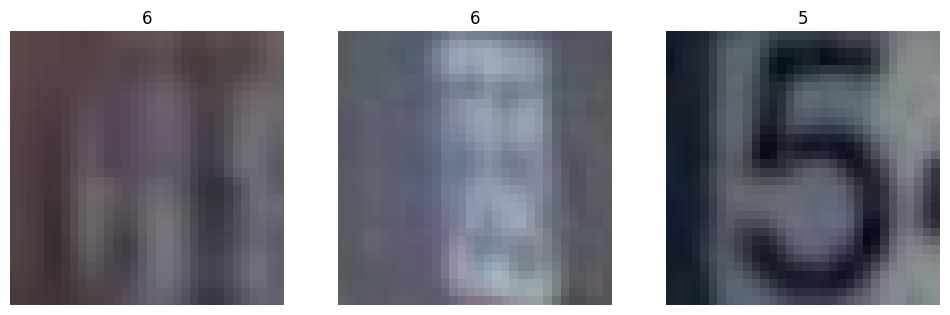

In [ ]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms


# load data
data = loadmat("/content/train_32x32.mat")
X = data['X']
y = data['y']
print(f"Shape of X: {X.shape}")
X = np.transpose(X, (3, 0, 1, 2))
print(f"Shape of new X: {X.shape}")


# present random image
random_image = np.random.choice(X.shape[0], 3, replace=False)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, ax in enumerate(axes):
    idx = random_image[i]
    ax.imshow(X[idx]) # image
    ax.set_title(y[idx][0])  # label
    ax.axis('off')
plt.show()

# 2. Data preperation

In [ ]:
# normalize data
X = X / 255.0
IMAGE_NUMBER = y.shape[0]


# inhance data
transform = transforms.Compose([
    transforms.RandomRotation(15), # rotate angle 15
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)), # cuts parts of imgae
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1) # change image colors
])

# create tensors
X_train_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)
Y_train_tensor = torch.tensor(y.flatten() % 10, dtype=torch.long)

X_train_tensor = torch.stack([transform(image) for image in X_train_tensor])

# 3. Create CNN model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) # 32 filters 32x32 px
        self.bn1 = nn.BatchNorm2d(32) # normalized batch to 32

        self.conv2 = nn.Conv2d(32, 128, kernel_size=5, stride=2, padding=2) # 128 filters 16x16 px
        self.bn2 = nn.BatchNorm2d(128) # normalized batch to 128

        self.conv3 = nn.Conv2d(128, 256, kernel_size=7, stride=1, padding=3)  # 256 filters 16x16 px
        self.bn3 = nn.BatchNorm2d(256) # normalized batch to 256

        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1) # 256 filters 16x16 px
        self.bn4 = nn.BatchNorm2d(256) # normalized batch to 256

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 256 filters 8x8 px
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.3)

        self.fc1 = nn.Linear(256 * 4 * 4, 256) # 256 neurons after flattening
        self.fc2 = nn.Linear(256, 128) # 128 neurons
        self.fc3 = nn.Linear(128, 10) # 10 neurons

    def forward(self, x):
        # 1 convolutional layer with ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        # 2 convolutional layer with ReLU
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        # 3 convolutional layer with ReLU
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = x.view(x.size(0), -1)

        # dropout
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))

        x = self.dropout2(x)
        x = F.relu(self.fc2(x))

        x = self.dropout3(x)
        x = self.fc3(x)
        return x

# 4. Set Train Function

In [ ]:
BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 0.001

# create Dataloader
train_data = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# initizlize model
model = CNN()

# create loss function
criterion = nn.CrossEntropyLoss()

# create Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2,
    verbose=True
)

def train(model, train_loader, criterion, optimizer, scheduler, epochs):
    model.to('cuda')
    model.train()
    history = {'loss': [], 'accuracy': []}

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            # zero the gradients for optimizer
            optimizer.zero_grad()
            # get model outputs
            outputs = model(inputs)
            # calculate loss values
            loss = criterion(outputs, labels)
            # backpropagation to compute the gradients
            loss.backward()
            # normalized gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            # update model parameters for optimizer
            optimizer.step()
            # add loss
            running_loss += loss.item()
            # get prediction (calc probability between prediction and 1)
            num, predicted = torch.max(outputs, 1)
            # count all predictions
            total += labels.size(0)
            # count correct predictions
            correct += (predicted == labels).sum().item()


        epoch_loss = running_loss / len(train_loader) # calc avarage lost
        epoch_accuracy = 100 * correct / total # calc accuracy

        # append data for presentation
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_accuracy)

        # print data
        print(f'Epoch [{epoch+1}/{epochs}], '
              f'Loss: {epoch_loss:.4f}, '
              f'Accuracy: {epoch_accuracy:.2f}%')
        scheduler.step(epoch_accuracy)

    return history


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# 7. Grid search - parameters adjustments

In [ ]:
from itertools import product

def grid_search(train_loader, criterion):
    param_grid = {
        'epochs': [10, 20],
        'learning_rate': [0.001, 0.0001],
        'batch_size': [64, 128]
    }

    best_params = None
    best_accuracy = 0

    for epochs, lr, batch_size in product(param_grid['epochs'], param_grid['learning_rate'], param_grid['batch_size']):
        print(f"\nTraining with epochs={epochs}, learning_rate={lr}, batch_size={batch_size}")

        # take currect batch
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        model = CNN().to('cuda')
        # set Adam optimizer
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
        # set learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=False)
        # train model to get calc best parameters
        history = train(model, train_loader, criterion, optimizer, scheduler, epochs)

        # update the best parameters
        final_accuracy = history['accuracy'][-1]
        if final_accuracy > best_accuracy:
            best_accuracy = final_accuracy
            best_params = {
                'epochs': epochs,
                'learning_rate': lr,
                'batch_size': batch_size
            }

    print(f"Best parameters found: {best_params} with accuracy {best_accuracy:.2f}%")
    return best_params

# calc best parameters
best_params = grid_search(train_loader, criterion)


Training with epochs=10, learning_rate=0.001, batch_size=64
Epoch [1/10], Loss: 1.9105, Accuracy: 30.92%
Epoch [2/10], Loss: 1.2401, Accuracy: 56.44%
Epoch [3/10], Loss: 0.9189, Accuracy: 69.56%
Epoch [4/10], Loss: 0.6992, Accuracy: 78.16%
Epoch [5/10], Loss: 0.5761, Accuracy: 82.42%
Epoch [6/10], Loss: 0.4888, Accuracy: 85.26%
Epoch [7/10], Loss: 0.4196, Accuracy: 87.37%
Epoch [8/10], Loss: 0.3676, Accuracy: 89.05%
Epoch [9/10], Loss: 0.3207, Accuracy: 90.37%
Epoch [10/10], Loss: 0.2839, Accuracy: 91.53%

Training with epochs=10, learning_rate=0.001, batch_size=128
Epoch [1/10], Loss: 1.8668, Accuracy: 32.96%
Epoch [2/10], Loss: 1.0558, Accuracy: 65.17%
Epoch [3/10], Loss: 0.7726, Accuracy: 75.58%
Epoch [4/10], Loss: 0.6445, Accuracy: 79.96%
Epoch [5/10], Loss: 0.5515, Accuracy: 82.89%
Epoch [6/10], Loss: 0.4853, Accuracy: 85.11%
Epoch [7/10], Loss: 0.4295, Accuracy: 86.94%
Epoch [8/10], Loss: 0.3789, Accuracy: 88.51%
Epoch [9/10], Loss: 0.3340, Accuracy: 90.02%
Epoch [10/10], Loss: 

# 4. Train Best Parameters

In [ ]:
# best parameters found in grid_search
EPOCHS = best_params['epochs']
LEARNING_RATE = best_params['learning_rate']
BATCH_SIZE = best_params['batch_size']

# initialize data loader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# initialize learning rate, and activation function (Adam)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# tarin model
history = train(model, train_loader, criterion, optimizer, scheduler, EPOCHS)


Epoch [1/20], Loss: 1.9247, Accuracy: 30.88%
Epoch [2/20], Loss: 1.0838, Accuracy: 63.89%
Epoch [3/20], Loss: 0.8004, Accuracy: 74.47%
Epoch [4/20], Loss: 0.6701, Accuracy: 78.96%
Epoch [5/20], Loss: 0.5710, Accuracy: 82.48%
Epoch [6/20], Loss: 0.4947, Accuracy: 84.78%
Epoch [7/20], Loss: 0.4296, Accuracy: 87.06%
Epoch [8/20], Loss: 0.3784, Accuracy: 88.63%
Epoch [9/20], Loss: 0.3320, Accuracy: 89.97%
Epoch [10/20], Loss: 0.2942, Accuracy: 91.04%
Epoch [11/20], Loss: 0.2595, Accuracy: 92.27%
Epoch [12/20], Loss: 0.2302, Accuracy: 93.11%
Epoch [13/20], Loss: 0.2050, Accuracy: 93.90%
Epoch [14/20], Loss: 0.1781, Accuracy: 94.60%
Epoch [15/20], Loss: 0.1615, Accuracy: 95.05%
Epoch [16/20], Loss: 0.1438, Accuracy: 95.63%
Epoch [17/20], Loss: 0.1274, Accuracy: 96.14%
Epoch [18/20], Loss: 0.1188, Accuracy: 96.36%
Epoch [19/20], Loss: 0.1066, Accuracy: 96.71%
Epoch [20/20], Loss: 0.1007, Accuracy: 96.89%


# 5. Evaluation

RESULTS:
Test Loss: 0.0687
Test Accuracy: 97.78%


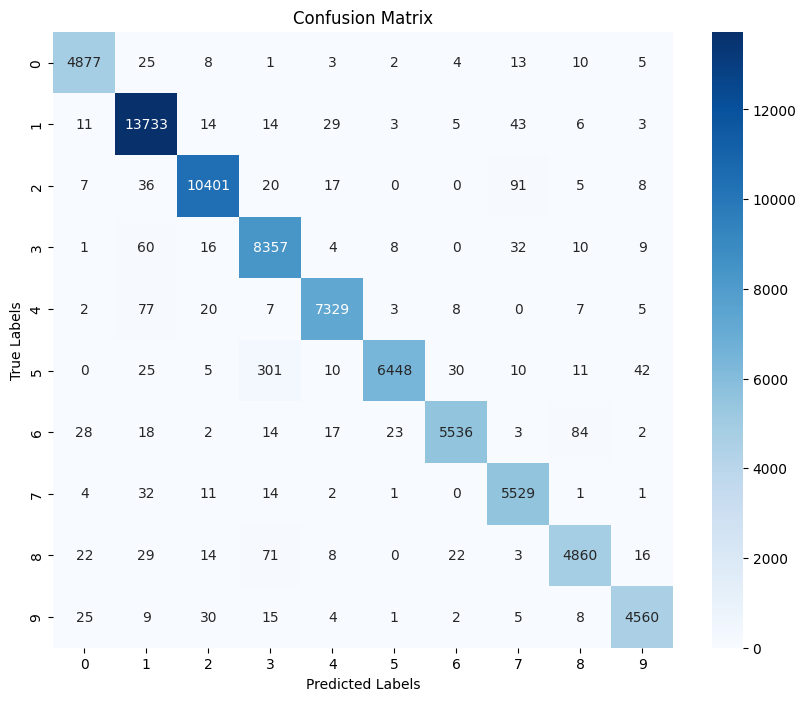


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4948
           1       0.98      0.99      0.98     13861
           2       0.99      0.98      0.99     10585
           3       0.95      0.98      0.97      8497
           4       0.99      0.98      0.99      7458
           5       0.99      0.94      0.96      6882
           6       0.99      0.97      0.98      5727
           7       0.97      0.99      0.98      5595
           8       0.97      0.96      0.97      5045
           9       0.98      0.98      0.98      4659

    accuracy                           0.98     73257
   macro avg       0.98      0.98      0.98     73257
weighted avg       0.98      0.98      0.98     73257



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# evaluate model
def evaluate(model, test_loader, criterion):
    model.to('cuda')
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad(): # turn off gradient (we didnt use it because we onlt evaluating)
        for inputs, labels in test_loader:
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            # get outputs from model
            outputs = model(inputs)
            # calc loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            num, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # calc accuracy and loss
    accuracy = 100 * correct / total
    avg_loss = running_loss / len(test_loader)

    print(f'RESULTS:\nTest Loss: {avg_loss:.4f}\nTest Accuracy: {accuracy:.2f}%')
    return all_labels, all_predictions, accuracy, avg_loss


# confussion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

# test group
test_data = TensorDataset(X_train_tensor, Y_train_tensor)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# evaluation
labels, predictions, test_accuracy, test_loss = evaluate(model, test_loader, criterion)

# catagories (digits 0-9)
class_names = [str(i) for i in range(10)]

# present data
plot_confusion_matrix(labels, predictions, class_names)

# 6. Vizualization - loss & accuracy, kernel & features maps


loss and accuracy graph:


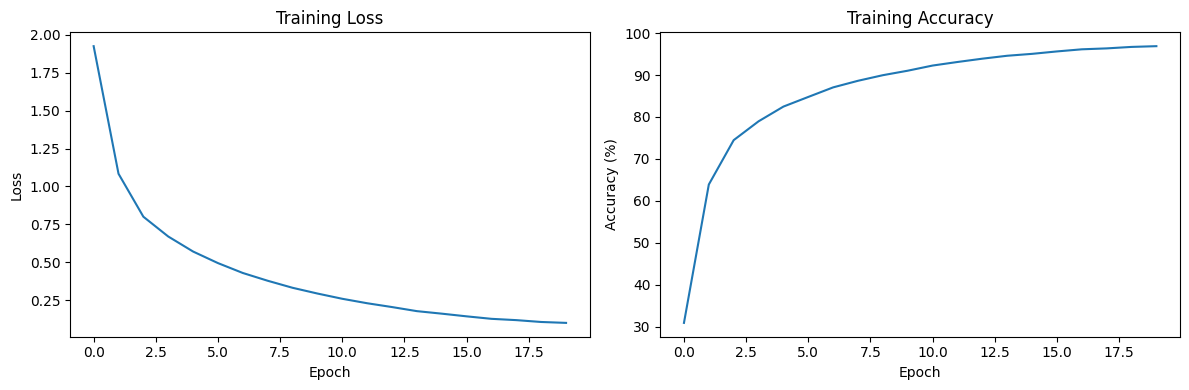



 kernel presentation:


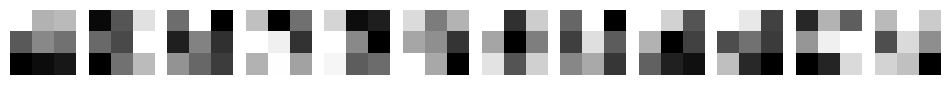



 Features map:


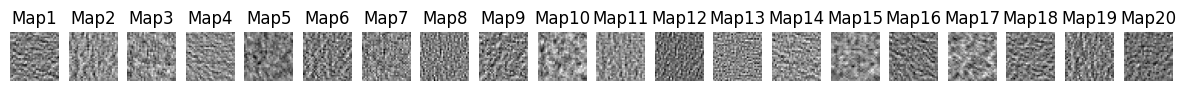

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# loss and accuracy graph
print("\nloss and accuracy graph:")
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.show()


# present filters pattern
def plot_filters(filters, num_filters=6, figsize=(10, 10)):
    num_filters = min(num_filters, filters.shape[0])
    fig, axes = plt.subplots(1, num_filters, figsize=figsize)
    for i in range(num_filters):
        filter_img = filters[i].detach().cpu().numpy()
        axes[i].imshow(filter_img[0, :, :], cmap='gray')
        axes[i].axis('off')
    plt.show()

print("\n\n kernel presentation:")
filters = model.conv1.weight
plot_filters(filters, num_filters=12, figsize=(12, 12))


# present feature maps
def plot_feature_maps(model, input_image):
    x = input_image.unsqueeze(0)
    x = x.to('cuda')
    x = model.conv1(x)

    num_filters = x.shape[1]
    num_filters = 20
    fig, axes = plt.subplots(1, num_filters, figsize=(15, 5))

    for i in range(num_filters):
        ax = axes[i]
        feature_map = x[0, i].cpu().detach().numpy()
        ax.imshow(feature_map, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Map{i+1}')

    plt.show()

print("\n\n Features map:")
input_image = torch.randn(3, 32, 32)
plot_feature_maps(model, input_image)